In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
df = pd.read_pickle("outputs/df.pickle")

In [32]:
df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,max_acceleration,max_gyro,Speed_abs
0,1194000908341,4.000,203.000000,1.001973,9.745000,-0.790087,-0.066046,0.019175,0.044741,246.0,6.480000,1,9.745000,0.044741,6.480000
1,1099511627891,3.000,311.000000,0.452518,9.273026,3.098191,0.005382,0.002155,-0.001436,66.0,0.340365,0,9.273026,0.005382,0.340365
2,962072674446,10.000,142.807999,0.018542,-8.041156,-4.960114,0.004223,-0.014875,0.007397,1552.0,2.050000,0,0.018542,0.007397,2.050000
3,1142461300867,8.000,171.205292,-0.290698,-8.295367,-3.049042,0.033618,0.046224,0.030559,277.0,17.608448,0,-0.290698,0.046224,17.608448
4,412316860548,19.379,0.000000,0.675613,8.846130,1.852508,-0.008652,0.003693,0.001160,148.0,0.000000,0,8.846130,0.003693,0.000000


### Max acceleration

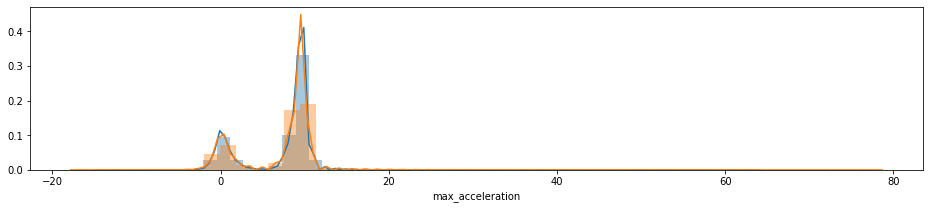

In [11]:
plt.figure(figsize=(16, 3))
sns.distplot(df.loc[df["label"] == 0]["max_acceleration"])
sns.distplot(df.loc[df["label"] == 1]["max_acceleration"])

### Max Gyro

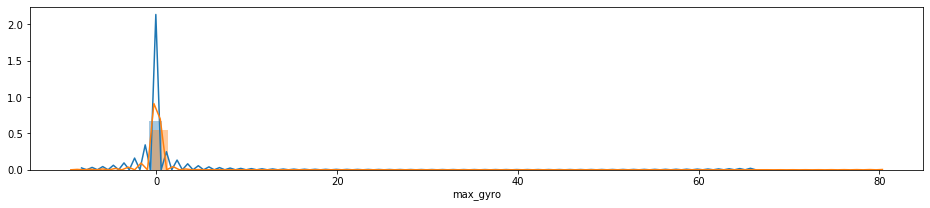

In [13]:
plt.figure(figsize=(16, 3))
sns.distplot(df.loc[df["label"] == 0]["max_gyro"])
sns.distplot(df.loc[df["label"] == 1]["max_gyro"])

## Mean speed

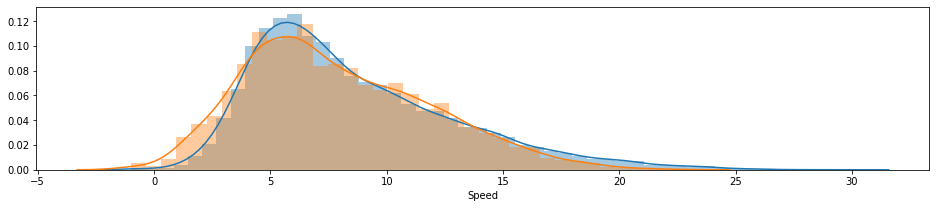

In [33]:
speed_data = df.groupby("bookingID").agg("mean")[["Speed", "label"]]
plt.figure(figsize=(16, 3))
sns.distplot(speed_data.loc[speed_data["label"]== 0]["Speed"])
sns.distplot(speed_data.loc[speed_data["label"]== 1]["Speed"])

### Bearing diff

In [ ]:
df_sorted = df.sort_values(["bookingID", "second"])
df_sorted["time_diffs"] = df_sorted["second"].diff()
df_sorted["Bearing_diffs"] = df_sorted["Bearing"].diff()
mask = df_sorted["bookingID"] != df_sorted["bookingID"].shift(1)
df_sorted["time_diffs"][mask] = 0
df_sorted["Bearing_diffs"][mask] = 0
df_sorted["distance_covered"] = df_sorted["Speed_abs"] * df_sorted["time_diffs"]
df_sorted["Bearing_diffs"] = np.abs(df_sorted["Bearing_diffs"]) * df_sorted["Speed"]

In [ ]:
bearing_diff = df_sorted.groupby("bookingID").agg("mean")[["Bearing_diffs", "label"]]
plt.figure(figsize=(16, 3))
sns.distplot(bearing_diff.loc[speed_data["label"]== 0]["Bearing_diffs"])
sns.distplot(bearing_diff.loc[speed_data["label"]== 1]["Bearing_diffs"])